# Reinforcement

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import time

### Environment  Setup

In [5]:
class GridWorld:
    def __init__(self, size=10, goal_state=100, walls=None):
        self.size = size
        self.goal_state = goal_state
        self.walls = walls if walls is not None else []
        self.actions = ['up', 'down', 'left', 'right']
        self.reset()
    
    def reset(self):
        """Reset to initial state"""
        self.current_state = 1
        return self.current_state
    
    def state_to_coords(self, state):
        """Convert state number to (row, col) coordinates"""
        row = (state - 1) // self.size
        col = (state - 1) % self.size
        return row, col
    
    def coords_to_state(self, row, col):
        """Convert (row, col) coordinates to state number"""
        if row < 0 or row >= self.size or col < 0 or col >= self.size:
            return None
        return row * self.size + col + 1
    
    def transition(self, state, action):
        """State transition function: f(s, a) = s'"""
        row, col = self.state_to_coords(state)
        
        if action == 'up':
            row -= 1
        elif action == 'down':
            row += 1
        elif action == 'left':
            col -= 1
        elif action == 'right':
            col += 1
        
        next_state = self.coords_to_state(row, col)
        
        # Check boundaries
        if next_state is None:
            return state, -0.1 if len(self.walls) > 0 else 0
        
        # Check walls
        if next_state in self.walls:
            return state, -0.1
        
        return next_state, 0
    
    def reward(self, state):
        """Reward function"""
        if state == self.goal_state:
            return 100
        return 0
    
    def step(self, action):
        """Execute action and return next state, reward, done"""
        next_state, wall_penalty = self.transition(self.current_state, action)
        reward = self.reward(next_state) + wall_penalty
        done = (next_state == self.goal_state)
        self.current_state = next_state
        return next_state, reward, done

In [7]:
env = GridWorld(size=10, goal_state=100)
print("Environment initialized")
print(f"Initial state: {env.current_state}")
print(f"Goal state: {env.goal_state}")

Environment initialized
Initial state: 1
Goal state: 100


### Q-Learning

In [8]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.7, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((n_states + 1, n_actions))  # +1 for 1-indexed states
        self.action_names = ['up', 'down', 'left', 'right']
    
    def get_best_action(self, state):
        """Get best action for state (random tie-breaking)"""
        q_values = self.Q[state]
        max_q = np.max(q_values)
        best_actions = np.where(q_values == max_q)[0]
        return np.random.choice(best_actions)
    
    def get_action(self, state, greed=1.0):
        """
        Get action using epsilon-greedy strategy.
        greed=1.0 means always best action, greed=0.0 means random
        """
        if np.random.random() < greed:
            return self.get_best_action(state)
        else:
            return np.random.randint(self.n_actions)
    
    def update(self, state, action, reward, next_state):
        """Update Q-table using Q-learning rule"""
        best_next_q = np.max(self.Q[next_state])
        target = reward + self.gamma * best_next_q
        self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * target
    
    def get_q_max(self):
        """Get maximum Q-value for each state"""
        return np.max(self.Q, axis=1)


## 3.

### 3.1

In [9]:
def train_qlearning(env, agent, n_steps, greed=1.0, test_points=None):
    """
    Train Q-learning agent.
    If test_points provided, run tests at those steps.
    """
    if test_points is None:
        test_points = []
    
    test_results = []
    step = 0
    episode_steps = 0
    
    state = env.reset()
    
    while step < n_steps:
        # Select and execute action
        action = agent.get_action(state, greed=greed)
        next_state, reward, done = env.step(agent.action_names[action])
        
        # Update Q-table
        agent.update(state, action, reward, next_state)
        
        state = next_state
        step += 1
        episode_steps += 1
        
        # Check for test point
        if step in test_points:
            test_reward = run_test(env, agent, max_steps=1000)
            test_results.append((step, test_reward))
        
        # Reset if goal reached or max steps
        if done or episode_steps >= 1000:
            state = env.reset()
            episode_steps = 0
    
    return test_results

def run_test(env, agent, max_steps=1000):
    """Run test episode using only best actions"""
    state = env.reset()
    total_reward = 0
    
    for _ in range(max_steps):
        action = agent.get_best_action(state)
        next_state, reward, done = env.step(agent.action_names[action])
        total_reward += reward
        state = next_state
        
        if done:
            break
    
    return total_reward / max_steps


In [10]:
# Test with different greed values
print("Exercise 3.1 - Testing different greed parameters\n")

greed_values = [0.2, 0.5, 0.9]
n_tests = 30
n_steps = 20000
test_points = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

results_by_greed = {}

for greed in greed_values:
    print(f"Testing greed={greed}...")
    results_by_greed[greed] = []
    
    for seed in range(n_tests):
        np.random.seed(seed)
        env = GridWorld(size=10, goal_state=100)
        agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
        
        test_results = train_qlearning(env, agent, n_steps, greed=greed, test_points=test_points)
        results_by_greed[greed].append(test_results)
    
    print(f"  Completed {n_tests} runs\n")


Exercise 3.1 - Testing different greed parameters

Testing greed=0.2...
  Completed 30 runs

Testing greed=0.5...
  Completed 30 runs

Testing greed=0.9...
  Completed 30 runs



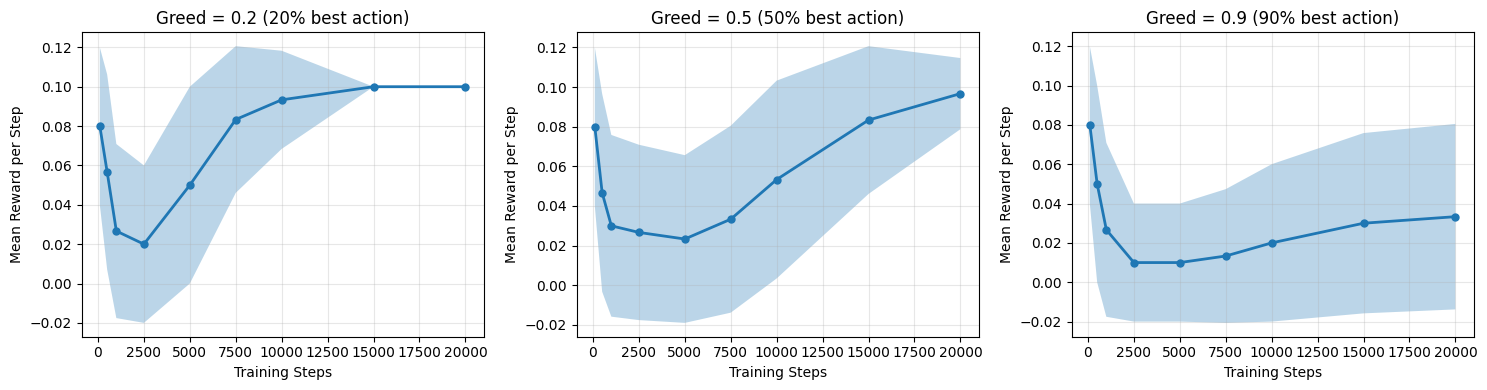


Final performance (at 20000 steps):
Greed 0.2: 0.1000 ± 0.0000
Greed 0.5: 0.0967 ± 0.0180
Greed 0.9: 0.0333 ± 0.0471


In [11]:
# Plot results for fixed greed

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, greed in enumerate(greed_values):
    ax = axes[idx]
    
    # Organize data by test point
    rewards_by_step = {step: [] for step in test_points}
    
    for test_run in results_by_greed[greed]:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    # Plot
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, 'o-', linewidth=2, markersize=5)
    ax.fill_between(steps, 
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.3)
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Mean Reward per Step')
    ax.set_title(f'Greed = {greed} ({int(greed*100)}% best action)')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal performance (at 20000 steps):")
for greed in greed_values:
    final_rewards = [test_run[-1][1] for test_run in results_by_greed[greed]]
    print(f"Greed {greed}: {np.mean(final_rewards):.4f} ± {np.std(final_rewards):.4f}")


## 3.2

In [12]:
def train_qlearning_increasing_greed(env, agent, n_steps, initial_greed=0.3, test_points=None):
    """
    Train with increasing greed: starts at initial_greed, increases to 1.0
    """
    if test_points is None:
        test_points = []
    
    test_results = []
    step = 0
    episode_steps = 0
    
    state = env.reset()
    
    # Calculate greed schedule
    greed_start_step = 0
    greed_end_step = int(n_steps * 0.3)  # First 30% at initial greed
    
    while step < n_steps:
        # Calculate current greed
        if step < greed_end_step:
            greed = initial_greed
        else:
            # Linear increase from initial_greed to 1.0
            progress = (step - greed_end_step) / (n_steps - greed_end_step)
            greed = initial_greed + (1.0 - initial_greed) * progress
        
        # Select and execute action
        action = agent.get_action(state, greed=greed)
        next_state, reward, done = env.step(agent.action_names[action])
        
        # Update Q-table
        agent.update(state, action, reward, next_state)
        
        state = next_state
        step += 1
        episode_steps += 1
        
        # Check for test point
        if step in test_points:
            test_reward = run_test(env, agent, max_steps=1000)
            test_results.append((step, test_reward))
        
        # Reset if goal reached or max steps
        if done or episode_steps >= 1000:
            state = env.reset()
            episode_steps = 0
    
    return test_results

print("Exercise 3.2 - Testing increasing greed parameter\n")

results_increasing = []

for seed in range(n_tests):
    np.random.seed(seed)
    env = GridWorld(size=10, goal_state=100)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3, 
                                                     test_points=test_points)
    results_increasing.append(test_results)

print(f"Completed {n_tests} runs with increasing greed\n")


Exercise 3.2 - Testing increasing greed parameter

Completed 30 runs with increasing greed



C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_15772\248277684.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(final_rewards, labels=strategies)


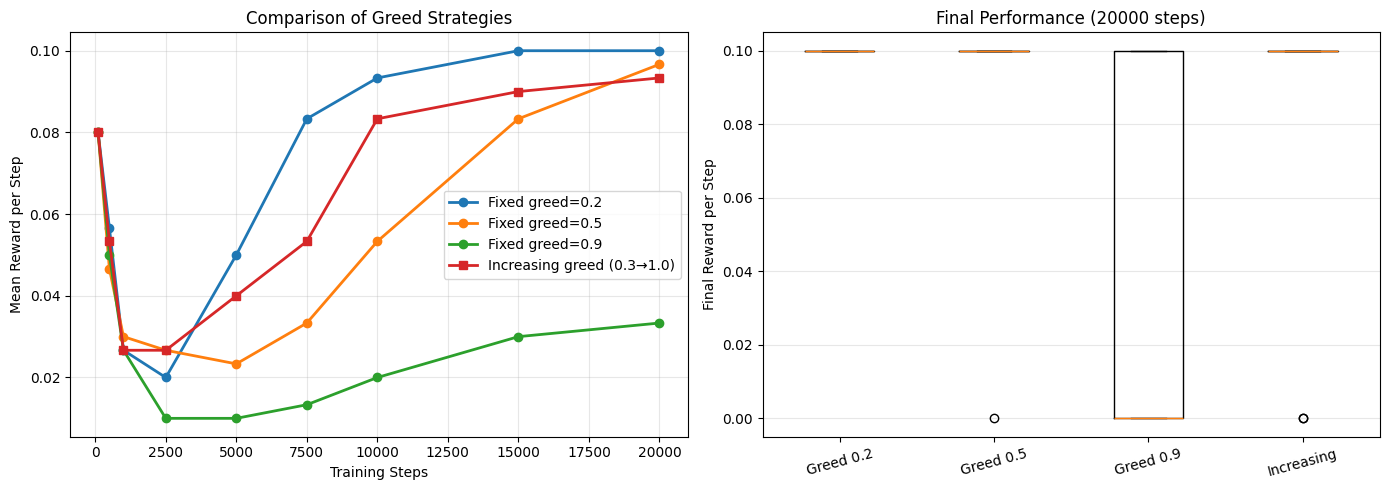


Final performance comparison (at 20000 steps):
Strategy             Mean       Std       
----------------------------------------
Greed 0.2            0.1000    0.0000
Greed 0.5            0.0967    0.0180
Greed 0.9            0.0333    0.0471
Increasing           0.0933    0.0249

Conclusions:
- Low greed (0.2): High exploration, slow convergence
- High greed (0.9): Fast initial learning, may miss optimal policy
- Increasing greed: Balances exploration and exploitation
- Best strategy typically: increasing greed or moderate fixed greed (0.5)


In [13]:
# Compare all greed strategies

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All strategies over time
for greed in greed_values:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results_by_greed[greed]:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    ax1.plot(steps, means, 'o-', label=f'Fixed greed={greed}', linewidth=2)

# Add increasing greed
rewards_by_step = {step: [] for step in test_points}
for test_run in results_increasing:
    for step, reward in test_run:
        rewards_by_step[step].append(reward)

steps = list(rewards_by_step.keys())
means = [np.mean(rewards_by_step[s]) for s in steps]
ax1.plot(steps, means, 's-', label='Increasing greed (0.3→1.0)', linewidth=2, markersize=6)

ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Mean Reward per Step')
ax1.set_title('Comparison of Greed Strategies')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Final performance comparison
strategies = ['Greed 0.2', 'Greed 0.5', 'Greed 0.9', 'Increasing']
final_rewards = []

for greed in greed_values:
    rewards = [test_run[-1][1] for test_run in results_by_greed[greed]]
    final_rewards.append(rewards)

rewards = [test_run[-1][1] for test_run in results_increasing]
final_rewards.append(rewards)

ax2.boxplot(final_rewards, labels=strategies)
ax2.set_ylabel('Final Reward per Step')
ax2.set_title('Final Performance (20000 steps)')
ax2.grid(alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\nFinal performance comparison (at 20000 steps):")
print(f"{'Strategy':<20} {'Mean':<10} {'Std':<10}")
print("-" * 40)
for i, strategy in enumerate(strategies):
    mean_reward = np.mean(final_rewards[i])
    std_reward = np.std(final_rewards[i])
    print(f"{strategy:<20} {mean_reward:.4f}    {std_reward:.4f}")

print("\nConclusions:")
print("- Low greed (0.2): High exploration, slow convergence")
print("- High greed (0.9): Fast initial learning, may miss optimal policy")
print("- Increasing greed: Balances exploration and exploitation")
print("- Best strategy typically: increasing greed or moderate fixed greed (0.5)")



Visualizing learned Q-tables...



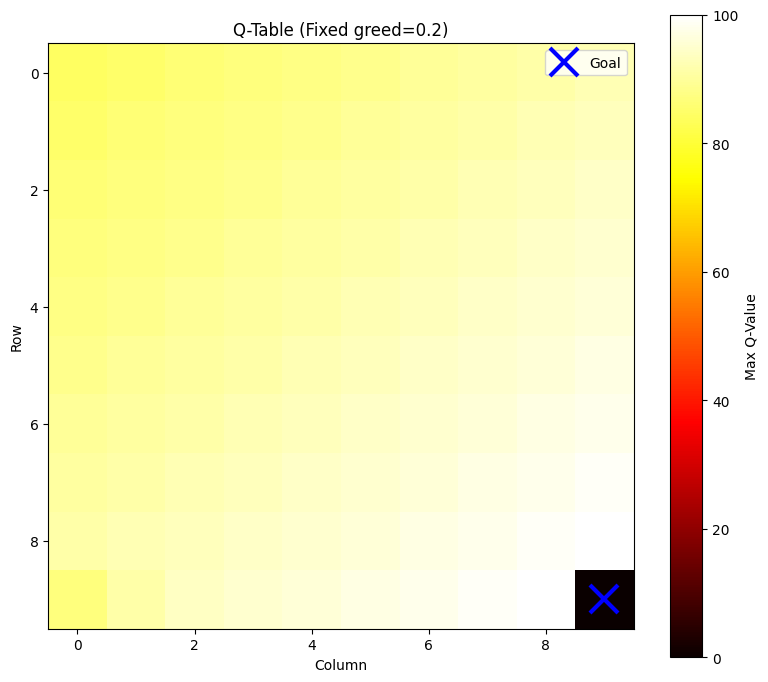

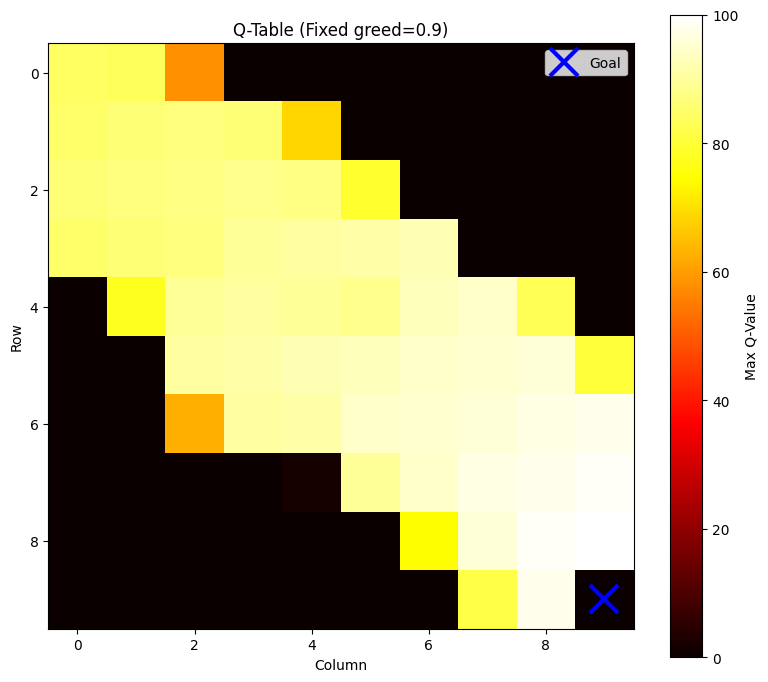

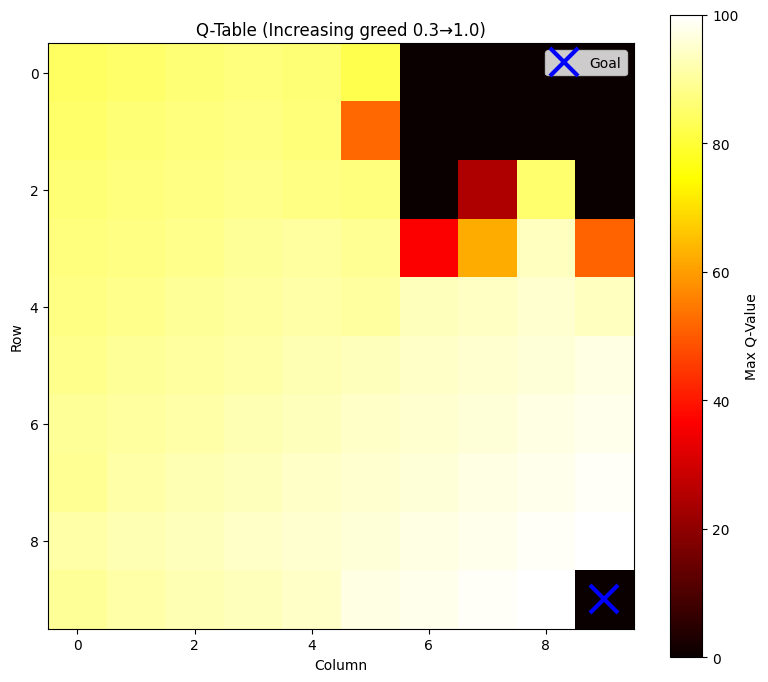

In [14]:
# Visualize learned Q-tables

def visualize_q_table(agent, env, title="Learned Q-Values"):
    """Visualize Q-table as heatmap"""
    q_max = agent.get_q_max()
    q_grid = q_max[1:101].reshape(env.size, env.size)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(q_grid, cmap='hot', interpolation='nearest')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Max Q-Value')
    
    # Mark goal
    goal_row, goal_col = env.state_to_coords(env.goal_state)
    ax.plot(goal_col, goal_row, 'bx', markersize=20, markeredgewidth=3, label='Goal')
    
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Visualize for different greed values
print("\nVisualizing learned Q-tables...\n")

for greed in [0.2, 0.9]:
    np.random.seed(42)
    env = GridWorld(size=10, goal_state=100)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    train_qlearning(env, agent, 20000, greed=greed)
    visualize_q_table(agent, env, title=f"Q-Table (Fixed greed={greed})")

# Increasing greed
np.random.seed(42)
env = GridWorld(size=10, goal_state=100)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table(agent, env, title="Q-Table (Increasing greed 0.3→1.0)")


## 4.

In [15]:
print("Exercise 4 - Adding walls to the environment\n")

# Define walls (example: create a maze-like structure)
walls = [
    13, 14, 15, 16, 17,  # Horizontal wall
    27, 37, 47, 57,      # Vertical wall
    73, 74, 75, 76, 77,  # Another horizontal wall
]

print(f"Number of walls: {len(walls)}")
print(f"Wall positions: {walls}\n")


Exercise 4 - Adding walls to the environment

Number of walls: 14
Wall positions: [13, 14, 15, 16, 17, 27, 37, 47, 57, 73, 74, 75, 76, 77]



### 4.1

In [16]:
results_with_walls = {greed: [] for greed in [0.5, 0.9]}
results_increasing_walls = []

print("Training with walls...\n")

# Test fixed greed values
for greed in [0.5, 0.9]:
    print(f"Testing greed={greed} with walls...")
    
    for seed in range(n_tests):
        np.random.seed(seed)
        env = GridWorld(size=10, goal_state=100, walls=walls)
        agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
        
        test_results = train_qlearning(env, agent, n_steps, greed=greed, test_points=test_points)
        results_with_walls[greed].append(test_results)
    
    print(f"  Completed {n_tests} runs\n")

# Test increasing greed
print("Testing increasing greed with walls...")
for seed in range(n_tests):
    np.random.seed(seed)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    
    test_results = train_qlearning_increasing_greed(env, agent, n_steps, 
                                                     initial_greed=0.3,
                                                     test_points=test_points)
    results_increasing_walls.append(test_results)

print(f"Completed {n_tests} runs\n")


Training with walls...

Testing greed=0.5 with walls...
  Completed 30 runs

Testing greed=0.9 with walls...
  Completed 30 runs

Testing increasing greed with walls...
Completed 30 runs



### 4.2

C:\Users\Ana Maria Ribeiro\AppData\Local\Temp\ipykernel_15772\2164275009.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


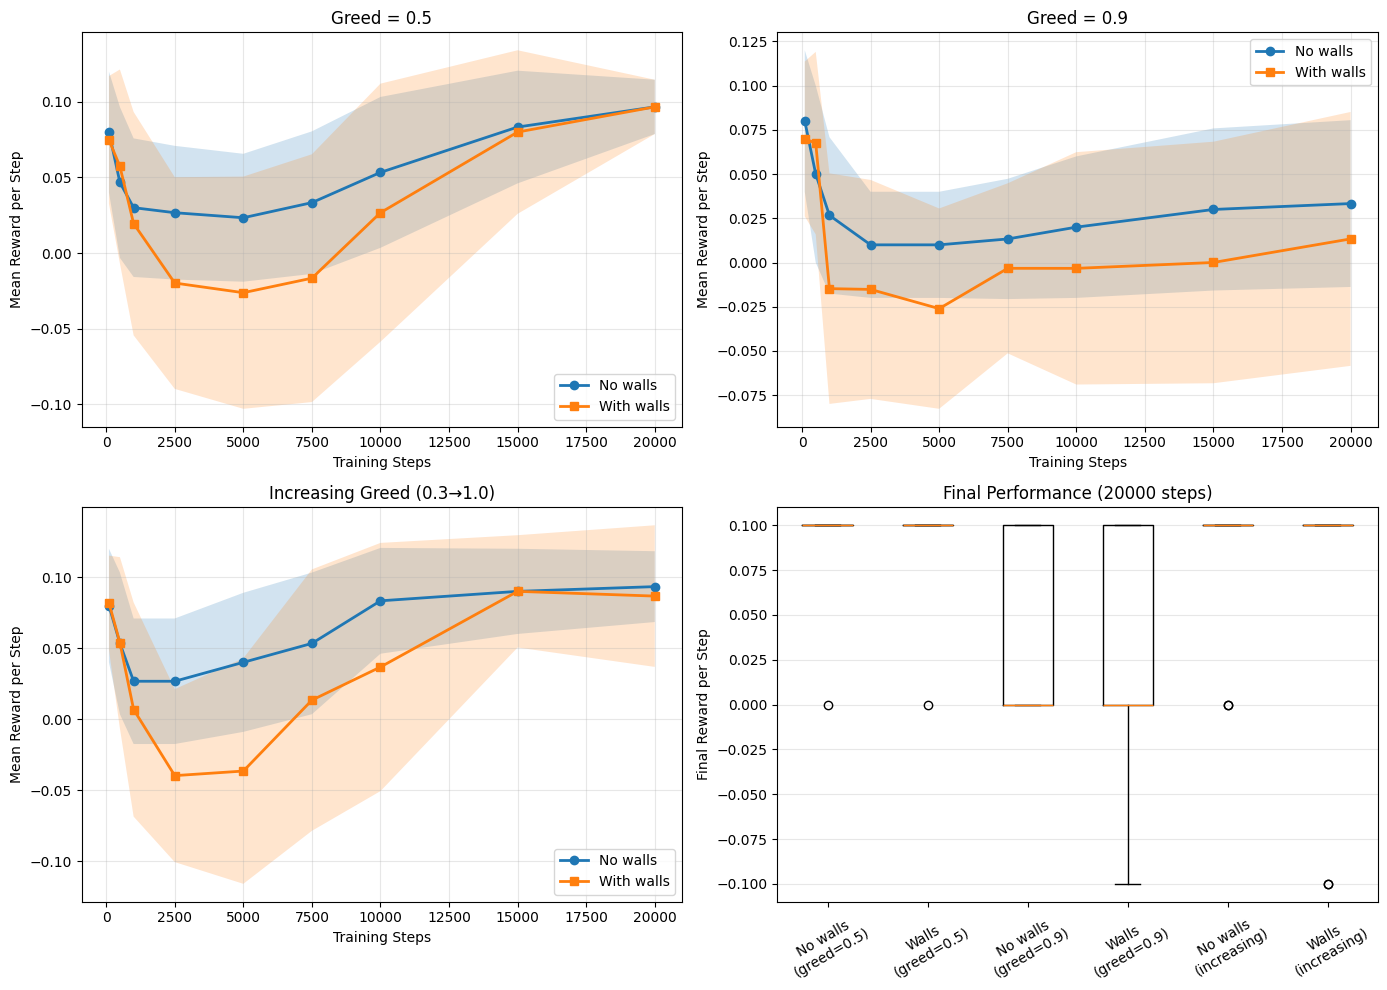


Final performance comparison:
Configuration                  Mean       Std       
--------------------------------------------------
No walls (greed=0.5)           0.0967    0.0180
Walls (greed=0.5)              0.0967    0.0180
No walls (greed=0.9)           0.0333    0.0471
Walls (greed=0.9)              0.0134    0.0718
No walls (increasing)          0.0933    0.0249
Walls (increasing)             0.0867    0.0499


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot for greed=0.5
ax = axes[0, 0]
for label, results, style in [('No walls', results_by_greed[0.5], 'o-'),
                               ('With walls', results_with_walls[0.5], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.5')
ax.legend()
ax.grid(alpha=0.3)

# Plot for greed=0.9
ax = axes[0, 1]
for label, results, style in [('No walls', results_by_greed[0.9], 'o-'),
                               ('With walls', results_with_walls[0.9], 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Greed = 0.9')
ax.legend()
ax.grid(alpha=0.3)

# Plot for increasing greed
ax = axes[1, 0]
for label, results, style in [('No walls', results_increasing, 'o-'),
                               ('With walls', results_increasing_walls, 's-')]:
    rewards_by_step = {step: [] for step in test_points}
    for test_run in results:
        for step, reward in test_run:
            rewards_by_step[step].append(reward)
    
    steps = list(rewards_by_step.keys())
    means = [np.mean(rewards_by_step[s]) for s in steps]
    stds = [np.std(rewards_by_step[s]) for s in steps]
    
    ax.plot(steps, means, style, label=label, linewidth=2)
    ax.fill_between(steps,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2)

ax.set_xlabel('Training Steps')
ax.set_ylabel('Mean Reward per Step')
ax.set_title('Increasing Greed (0.3→1.0)')
ax.legend()
ax.grid(alpha=0.3)

# Final performance comparison
ax = axes[1, 1]
labels = ['No walls\n(greed=0.5)', 'Walls\n(greed=0.5)', 
          'No walls\n(greed=0.9)', 'Walls\n(greed=0.9)',
          'No walls\n(increasing)', 'Walls\n(increasing)']
data = [
    [test_run[-1][1] for test_run in results_by_greed[0.5]],
    [test_run[-1][1] for test_run in results_with_walls[0.5]],
    [test_run[-1][1] for test_run in results_by_greed[0.9]],
    [test_run[-1][1] for test_run in results_with_walls[0.9]],
    [test_run[-1][1] for test_run in results_increasing],
    [test_run[-1][1] for test_run in results_increasing_walls]
]

ax.boxplot(data, labels=labels)
ax.set_ylabel('Final Reward per Step')
ax.set_title('Final Performance (20000 steps)')
ax.grid(alpha=0.3, axis='y')
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

print("\nFinal performance comparison:")
print(f"{'Configuration':<30} {'Mean':<10} {'Std':<10}")
print("-" * 50)
for i, label in enumerate(labels):
    mean_reward = np.mean(data[i])
    std_reward = np.std(data[i])
    print(f"{label.replace(chr(10), ' '):<30} {mean_reward:.4f}    {std_reward:.4f}")


### 4.3


Visualizing learned Q-tables with walls...



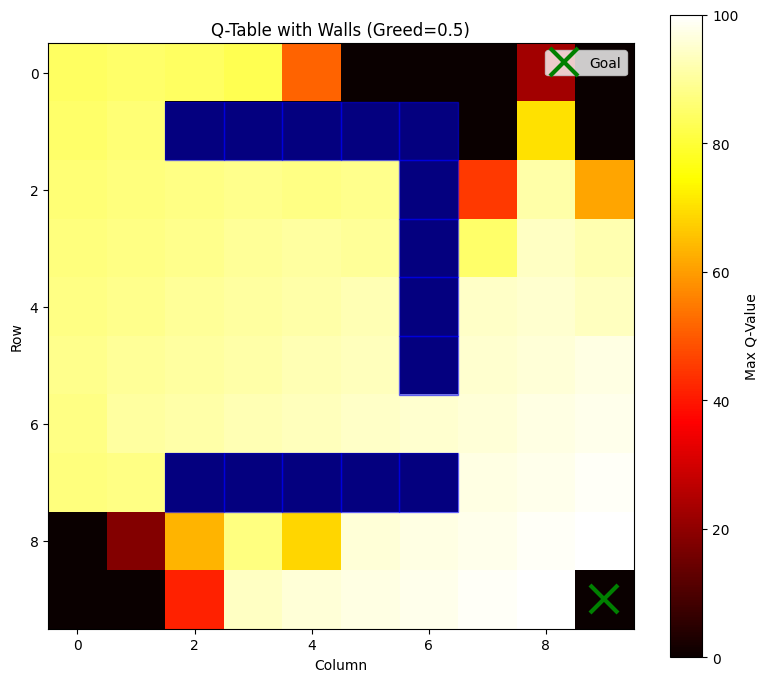

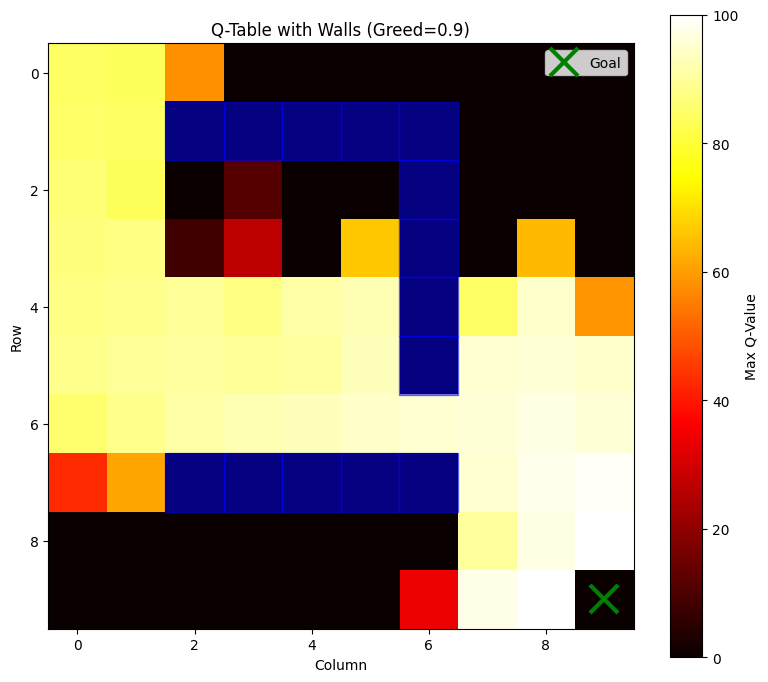

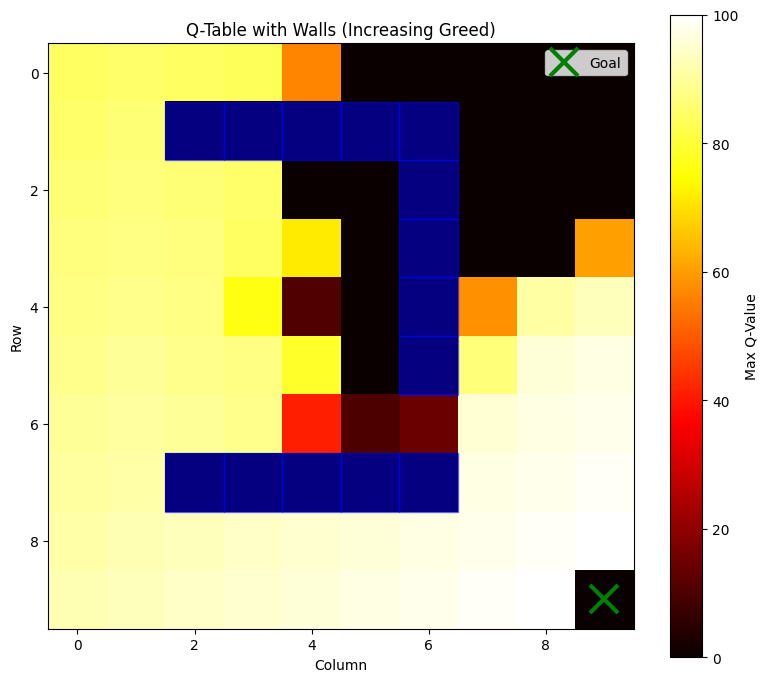

In [18]:
def visualize_q_table_with_walls(agent, env, title="Learned Q-Values with Walls"):
    """Visualize Q-table with walls marked"""
    q_max = agent.get_q_max()
    q_grid = q_max[1:101].reshape(env.size, env.size)
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(q_grid, cmap='hot', interpolation='nearest')
    
    # Mark walls
    for wall in env.walls:
        wall_row, wall_col = env.state_to_coords(wall)
        ax.add_patch(plt.Rectangle((wall_col-0.5, wall_row-0.5), 1, 1, 
                                    fill=True, color='blue', alpha=0.5))
    
    # Mark goal
    goal_row, goal_col = env.state_to_coords(env.goal_state)
    ax.plot(goal_col, goal_row, 'gx', markersize=20, markeredgewidth=3, label='Goal')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Max Q-Value')
    
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.legend()
    plt.tight_layout()
    plt.show()

print("\nVisualizing learned Q-tables with walls...\n")

# Train and visualize with different strategies
for greed, title_suffix in [(0.5, "Greed=0.5"), (0.9, "Greed=0.9")]:
    np.random.seed(42)
    env = GridWorld(size=10, goal_state=100, walls=walls)
    agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
    train_qlearning(env, agent, 20000, greed=greed)
    visualize_q_table_with_walls(agent, env, title=f"Q-Table with Walls ({title_suffix})")

# Increasing greed
np.random.seed(42)
env = GridWorld(size=10, goal_state=100, walls=walls)
agent = QLearningAgent(n_states=100, n_actions=4, alpha=0.7, gamma=0.99)
train_qlearning_increasing_greed(env, agent, 20000, initial_greed=0.3)
visualize_q_table_with_walls(agent, env, title="Q-Table with Walls (Increasing Greed)")
